# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/autoencoder_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1    2         3         4    5         6    7  \
41001 201546  0.0 -0.774825  0.0 -0.441353 -0.367556  0.0 -0.067683  0.0   
      201547  0.0 -0.774825  0.0 -0.441353 -0.367556  0.0 -0.067683  0.0   
      201548  0.0 -0.774825  0.0 -0.441353 -0.367556  0.0 -0.067683  0.0   
      201549  0.0 -0.774825  0.0 -0.441353 -0.367556  0.0 -0.067683  0.0   
      201550  0.0 -0.774825  0.0 -0.441353 -0.367556  0.0 -0.067683  0.0   

                     8         9  ...  1015      1016      1017  1018  \
41001 201546 -0.998565 -0.071943  ...   0.0 -0.921922 -0.210034   0.0   
      201547 -0.998565 -0.071943  ...   0.0 -0.921922 -0.210034   0.0   
      201548 -0.998565 -0.071943  ...   0.0 -0.921922 -0.210034   0.0   
      201549 -0.998565 -0.071943  ...   0.0 -0.921922 -0.210034   0.0   
      201550 -0.998565 -0.071943  ...   0.0 -0.921922 -0.210034   0.0   

                  1019  1020  1021  1022      1023    Labels  
41001 201546 -0.485437   0.0   0.0   0.0 -0.027746  0.064361  
      201547 -0.485437   0.0   0.0   0.0 -0.027746  0.091926  
      201548 -0.485437   0.0   0.0   0.0 -0.027746  0.082738  
      201549 -0.485437   0.0   0.0   0.0 -0.027746  0.082738  
      201550 -0.485437   0.0   0.0   0.0 -0.027746  0.211376  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1    2         3         4    5         6    7  \
41001 201820  0.0  0.620283  0.0 -0.441353 -0.367556  0.0 -0.067683  0.0   
      201821  0.0  1.829504  0.0  2.012544  3.602906  0.0 -0.067683  0.0   
      201822  0.0  1.245169  0.0  1.229173  0.564211  0.0 -0.067683  0.0   
      201823  0.0 -0.774825  0.0 -0.441353 -0.367556  0.0 -0.067683  0.0   
      201824  0.0  1.273921  0.0  1.772331 -0.367556  0.0 -0.067683  0.0   

                     8         9  ...  1015      1016      1017  1018  \
41001 201820 -0.209557 -0.071943  ...   0.0  1.247308 -0.210034   0.0   
      201821 -0.779635 -0.071943  ...   0.0  0.512457  3.015177   0.0   
      201822 -0.629153 -0.071943  ...   0.0  1.021035 -0.210034   0.0   
      201823  0.966329 -0.071943  ...   0.0 -0.921922 -0.210034   0.0   
      201824 -0.254736 -0.071943  ...   0.0  1.715252 -0.210034   0.0   

                  1019  1020  1021  1022      1023    Labels  
41001 201820 -0.485437   0.0   0.0   0.0 -0.027746 -0.275610  
      201821 -0.485437   0.0   0.0   0.0 -0.027746 -0.321552  
      201822 -0.485437   0.0   0.0   0.0 -0.027746 -0.238856  
      201823  0.990740   0.0   0.0   0.0 -0.027746 -0.321552  
      201824 -0.485437   0.0   0.0   0.0 -0.027746 -0.293986  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

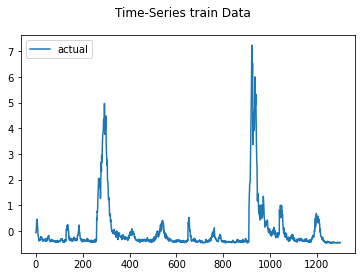

2023-03-15 04:14:55.441810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 04:14:55.441847: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 04:14:55.441872: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-15 04:14:55.442134: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 04:14:55.552906: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 41.974
Test RMSE: 58.653
Test sMAPE: 98.888
Test R Squared: -2.560
{'mae': 41.973927745584284, 'rmse': 58.65308688382487, 'smape': 98.88765651628876, 'r2': -2.5597848399066403}


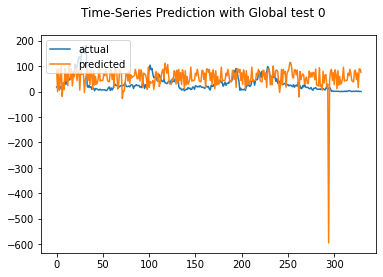

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 35.832
Test RMSE: 44.915
Test sMAPE: 100.270
Test R Squared: -1.087
{'mae': 35.832083107124674, 'rmse': 44.91472969149635, 'smape': 100.27014273238036, 'r2': -1.0874668255800075}


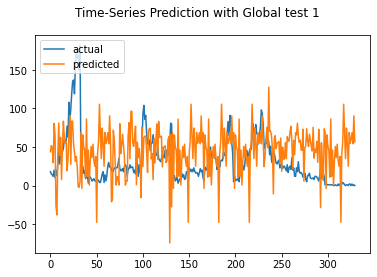

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 34.168
Test RMSE: 41.441
Test sMAPE: 93.580
Test R Squared: -0.777
{'mae': 34.167879093235186, 'rmse': 41.440615048722314, 'smape': 93.58020383191652, 'r2': -0.7770284733262922}


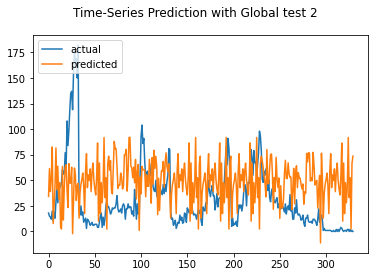

Test MAE: 30.596
Test RMSE: 38.466
Test sMAPE: 86.117
Test R Squared: -0.531
{'mae': 30.596270409497347, 'rmse': 38.465721293706764, 'smape': 86.11712225908941, 'r2': -0.5310513712574108}


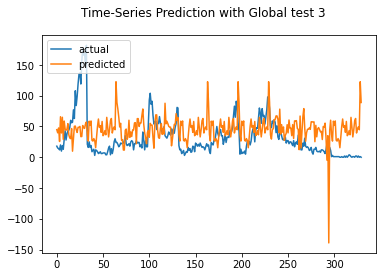

Test MAE: 32.592
Test RMSE: 39.815
Test sMAPE: 91.089
Test R Squared: -0.640
{'mae': 32.59200077923862, 'rmse': 39.814844149123466, 'smape': 91.08911790412677, 'r2': -0.6403330745469793}


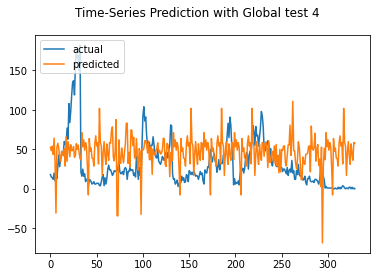

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 32.150
Test RMSE: 43.248
Test sMAPE: 93.794
Test R Squared: -0.935
{'mae': 32.14992347269347, 'rmse': 43.247726121863515, 'smape': 93.79354298199561, 'r2': -0.9353902899141189}


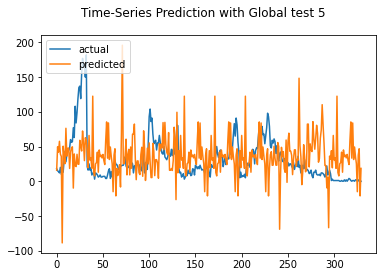

Test MAE: 37.134
Test RMSE: 43.559
Test sMAPE: 92.783
Test R Squared: -0.963
{'mae': 37.134170173876214, 'rmse': 43.559171265993314, 'smape': 92.78281933167496, 'r2': -0.9633657862093505}


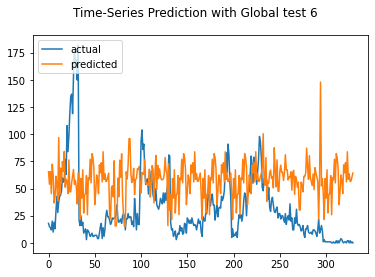

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 48.129
Test RMSE: 61.235
Test sMAPE: 111.163
Test R Squared: -2.880
{'mae': 48.12886060656923, 'rmse': 61.23454750012796, 'smape': 111.16262462207713, 'r2': -2.8800294994838294}


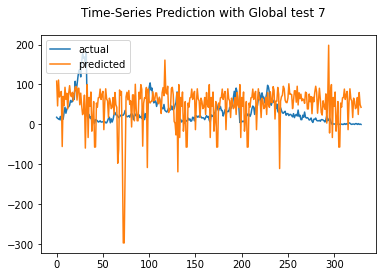

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 31.083
Test RMSE: 47.210
Test sMAPE: 110.514
Test R Squared: -1.306
{'mae': 31.08285853228052, 'rmse': 47.2097914517584, 'smape': 110.51390132054298, 'r2': -1.3062488426585892}


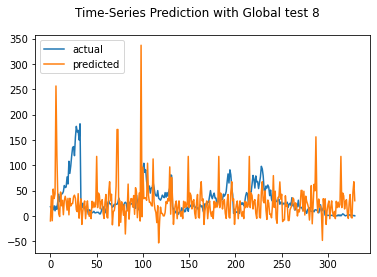

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 50.533
Test RMSE: 70.069
Test sMAPE: 103.222
Test R Squared: -4.080
{'mae': 50.53284948955883, 'rmse': 70.06860232450204, 'smape': 103.22168690330538, 'r2': -4.0802947597228405}


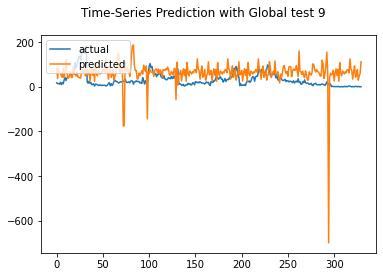

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 37.148
Test RMSE: 49.101
Test sMAPE: 100.934
Test R Squared: -1.495
{'mae': 37.14829437208898, 'rmse': 49.10092289090119, 'smape': 100.93437758702083, 'r2': -1.494717145761665}


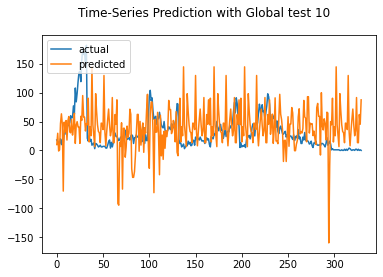

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 35.626
Test RMSE: 68.251
Test sMAPE: 111.366
Test R Squared: -3.820
{'mae': 35.62615707706321, 'rmse': 68.25051353110246, 'smape': 111.36562533997163, 'r2': -3.8200755846563856}


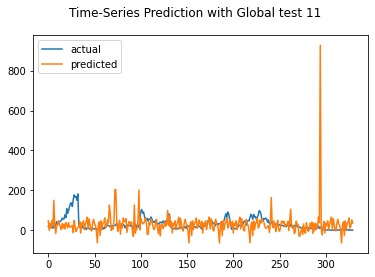

Test MAE: 38.464
Test RMSE: 46.236
Test sMAPE: 97.109
Test R Squared: -1.212
{'mae': 38.464416157115586, 'rmse': 46.23648678212391, 'smape': 97.10925281664785, 'r2': -1.212135149153565}


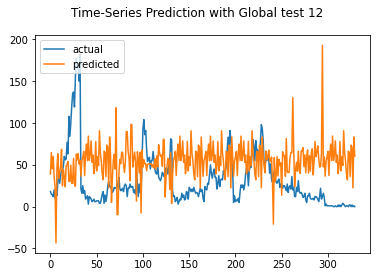

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 41.505
Test RMSE: 52.737
Test sMAPE: 97.337
Test R Squared: -1.878
{'mae': 41.50517817193811, 'rmse': 52.737026096218635, 'smape': 97.33673739510998, 'r2': -1.877883923908831}


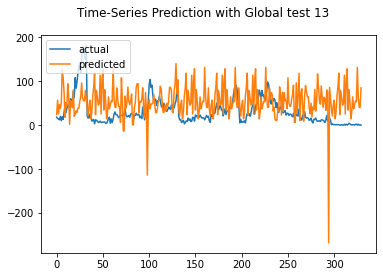

Test MAE: 33.296
Test RMSE: 44.801
Test sMAPE: 88.144
Test R Squared: -1.077
{'mae': 33.295584337639085, 'rmse': 44.801087162292056, 'smape': 88.14414465300202, 'r2': -1.0769168389783914}


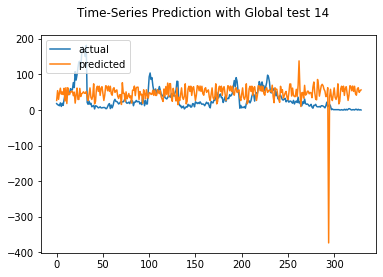

Test MAE: 34.989
Test RMSE: 41.122
Test sMAPE: 92.165
Test R Squared: -0.750
{'mae': 34.98920346173373, 'rmse': 41.12190826724543, 'smape': 92.16452477402102, 'r2': -0.7498004406075693}


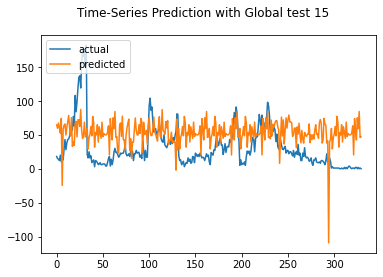

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 47.796
Test RMSE: 62.001
Test sMAPE: 110.222
Test R Squared: -2.978
{'mae': 47.79615444143613, 'rmse': 62.00106209084583, 'smape': 110.22150980096957, 'r2': -2.977775421028125}


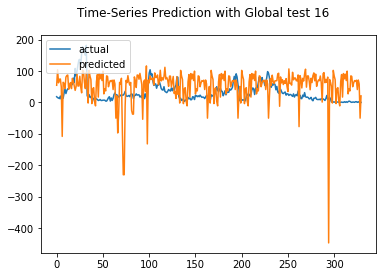

Test MAE: 40.284
Test RMSE: 46.933
Test sMAPE: 98.145
Test R Squared: -1.279
{'mae': 40.28368150826657, 'rmse': 46.932950735461446, 'smape': 98.14466028215367, 'r2': -1.2792802173008488}


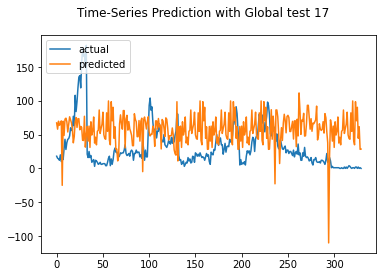

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 30.888
Test RMSE: 38.282
Test sMAPE: 88.292
Test R Squared: -0.516
{'mae': 30.887570456302527, 'rmse': 38.28218984282252, 'smape': 88.29243541821462, 'r2': -0.5164760188665172}


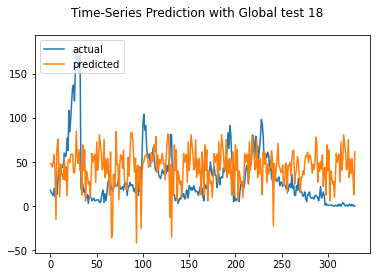

Test MAE: 35.009
Test RMSE: 50.700
Test sMAPE: 91.726
Test R Squared: -1.660
{'mae': 35.00921939954613, 'rmse': 50.70049474586804, 'smape': 91.72615246632729, 'r2': -1.659906656139174}


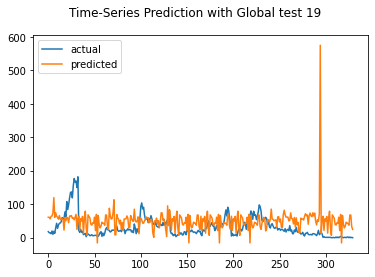

Test MAE: 35.024
Test RMSE: 50.546
Test sMAPE: 91.698
Test R Squared: -1.644
{'mae': 35.02391532551159, 'rmse': 50.5456565170582, 'smape': 91.69841719798974, 'r2': -1.6436848682079868}


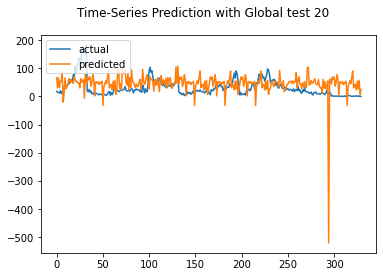

Test MAE: 35.369
Test RMSE: 47.713
Test sMAPE: 89.630
Test R Squared: -1.356
{'mae': 35.369247020374644, 'rmse': 47.713132859520286, 'smape': 89.63012079490484, 'r2': -1.355688536222214}


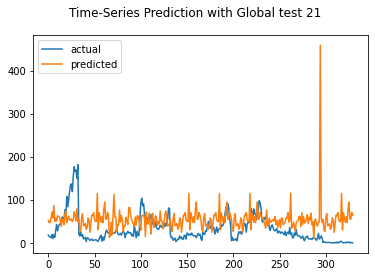

Test MAE: 35.814
Test RMSE: 44.193
Test sMAPE: 95.148
Test R Squared: -1.021
{'mae': 35.81402347629721, 'rmse': 44.192980066209415, 'smape': 95.14793369799041, 'r2': -1.0209174706241435}


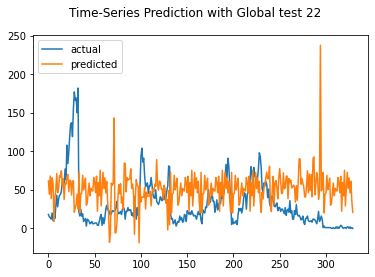

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 42.423
Test RMSE: 52.345
Test sMAPE: 111.677
Test R Squared: -1.835
{'mae': 42.42320454373504, 'rmse': 52.34464339975771, 'smape': 111.67727289345326, 'r2': -1.8352182300255264}


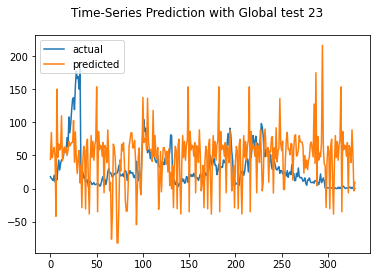

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 32.691
Test RMSE: 44.281
Test sMAPE: 104.630
Test R Squared: -1.029
{'mae': 32.69064966873689, 'rmse': 44.28084468187818, 'smape': 104.63007922135272, 'r2': -1.0289614475791136}


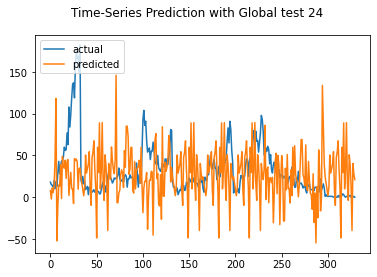

Test MAE: 32.675
Test RMSE: 44.564
Test sMAPE: 95.234
Test R Squared: -1.055
{'mae': 32.67480903502667, 'rmse': 44.563892772896956, 'smape': 95.23368552036978, 'r2': -1.0549830441931745}


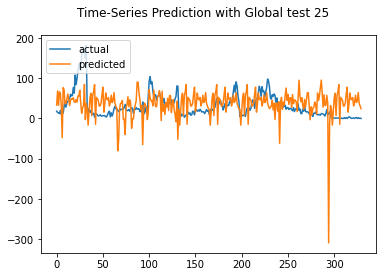

Test MAE: 42.178
Test RMSE: 49.347
Test sMAPE: 97.610
Test R Squared: -1.520
{'mae': 42.178493002689244, 'rmse': 49.346787497430775, 'smape': 97.6097924533114, 'r2': -1.519763449104004}


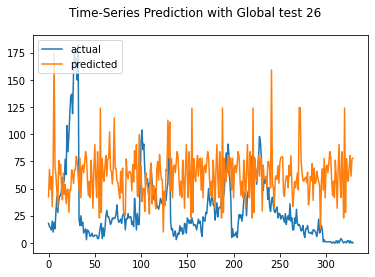

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 34.305
Test RMSE: 44.608
Test sMAPE: 93.470
Test R Squared: -1.059
{'mae': 34.30482984022661, 'rmse': 44.60833304639307, 'smape': 93.47032977662042, 'r2': -1.059083652922232}


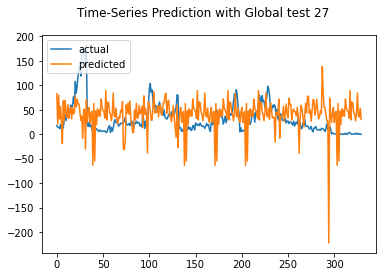

Test MAE: 38.156
Test RMSE: 49.266
Test sMAPE: 94.878
Test R Squared: -1.511
{'mae': 38.15631893132672, 'rmse': 49.265523946149926, 'smape': 94.87791694460896, 'r2': -1.5114712649627693}


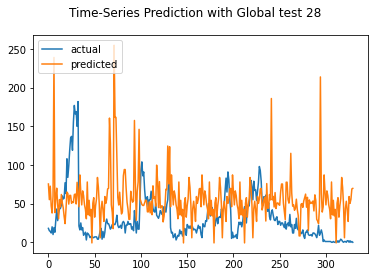

Test MAE: 36.693
Test RMSE: 48.326
Test sMAPE: 91.111
Test R Squared: -1.417
{'mae': 36.693262067527485, 'rmse': 48.32610552440881, 'smape': 91.11078764199532, 'r2': -1.4166045977794255}


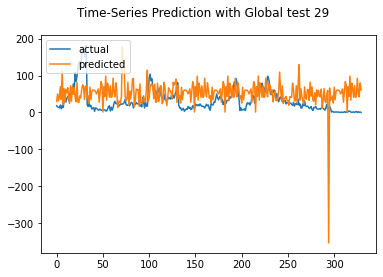

Test MAE: 33.600
Test RMSE: 43.717
Test sMAPE: 90.531
Test R Squared: -0.978
{'mae': 33.600349825440034, 'rmse': 43.7173918450905, 'smape': 90.53134129863524, 'r2': -0.9776548115721646}


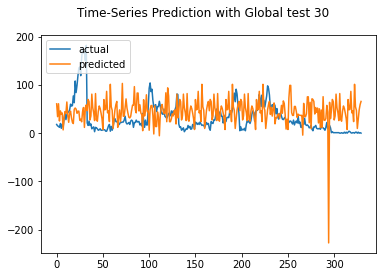

Test MAE: 41.231
Test RMSE: 47.968
Test sMAPE: 97.953
Test R Squared: -1.381
{'mae': 41.230657905701435, 'rmse': 47.96772106233313, 'smape': 97.95318059962396, 'r2': -1.3808946167606}


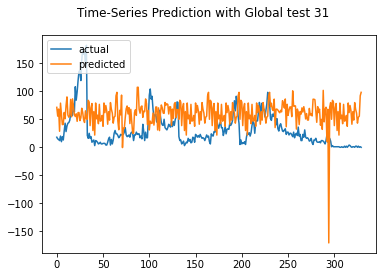

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 39.478
Test RMSE: 53.318
Test sMAPE: 102.031
Test R Squared: -1.942
{'mae': 39.477691347671275, 'rmse': 53.317564917057744, 'smape': 102.03084417582352, 'r2': -1.941593210456578}


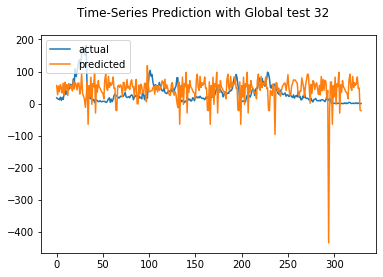

Test MAE: 35.138
Test RMSE: 43.013
Test sMAPE: 93.220
Test R Squared: -0.914
{'mae': 35.13816985506, 'rmse': 43.01276050349751, 'smape': 93.22027895973498, 'r2': -0.9144174025849774}


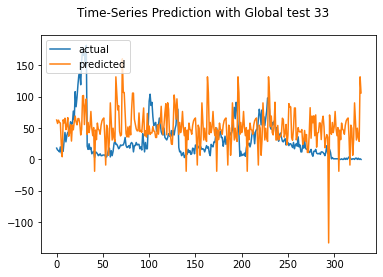

Test MAE: 37.233
Test RMSE: 43.904
Test sMAPE: 92.959
Test R Squared: -0.995
{'mae': 37.232574954177394, 'rmse': 43.904157396478354, 'smape': 92.9585634200146, 'r2': -0.9945884274381209}


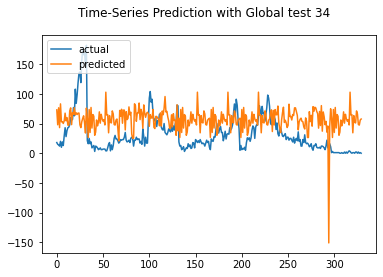

Test MAE: 33.604
Test RMSE: 45.230
Test sMAPE: 95.408
Test R Squared: -1.117
{'mae': 33.6044747038321, 'rmse': 45.22958038870777, 'smape': 95.40805907082994, 'r2': -1.1168355429750396}


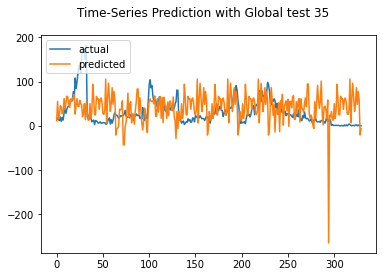

Test MAE: 36.165
Test RMSE: 48.539
Test sMAPE: 92.368
Test R Squared: -1.438
{'mae': 36.16455165834138, 'rmse': 48.538555081630705, 'smape': 92.36763409159515, 'r2': -1.4378988891911568}


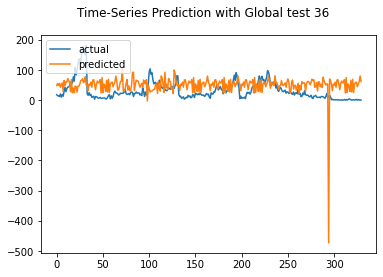

Test MAE: 31.853
Test RMSE: 41.241
Test sMAPE: 93.168
Test R Squared: -0.760
{'mae': 31.853087610909434, 'rmse': 41.240803246005676, 'smape': 93.16796303745004, 'r2': -0.7599333964751267}


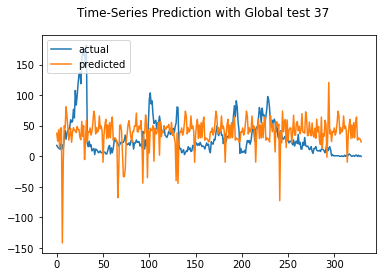

Test MAE: 34.312
Test RMSE: 43.312
Test sMAPE: 89.083
Test R Squared: -0.941
{'mae': 34.3115409041896, 'rmse': 43.311937203407965, 'smape': 89.08328617820194, 'r2': -0.9411416100880463}


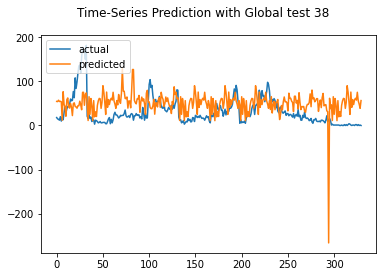

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 36.367
Test RMSE: 45.693
Test sMAPE: 98.444
Test R Squared: -1.160
{'mae': 36.36732274817698, 'rmse': 45.69270097208561, 'smape': 98.4442442930406, 'r2': -1.160407434073297}


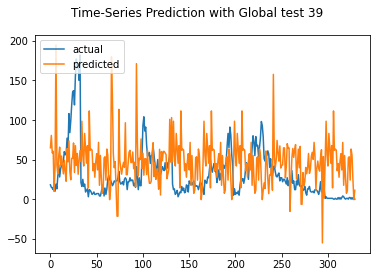

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 35.284
Test RMSE: 50.452
Test sMAPE: 97.888
Test R Squared: -1.634
{'mae': 35.28354071157448, 'rmse': 50.45197314418427, 'smape': 97.88848599087426, 'r2': -1.633894124071483}


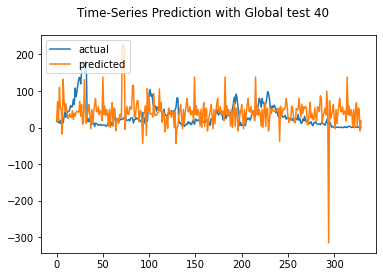

Test MAE: 34.066
Test RMSE: 44.138
Test sMAPE: 90.076
Test R Squared: -1.016
{'mae': 34.066032213153264, 'rmse': 44.13820958601853, 'smape': 90.07595116744139, 'r2': -1.0159113347850424}


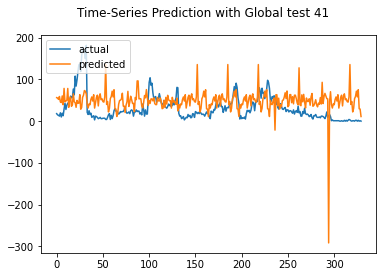

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 38.659
Test RMSE: 46.485
Test sMAPE: 98.587
Test R Squared: -1.236
{'mae': 38.659224861318414, 'rmse': 46.48534349920554, 'smape': 98.58697216357834, 'r2': -1.236011797602019}


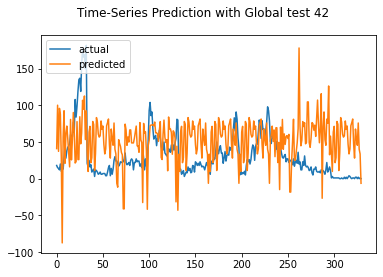

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 39.643
Test RMSE: 48.099
Test sMAPE: 96.501
Test R Squared: -1.394
{'mae': 39.642984144615404, 'rmse': 48.09919968540459, 'smape': 96.5012777407742, 'r2': -1.3939644792793953}


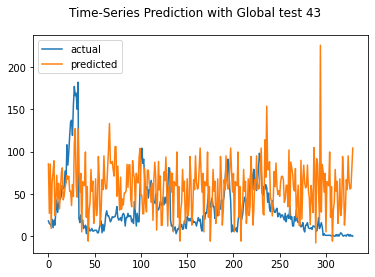

Test MAE: 32.971
Test RMSE: 42.892
Test sMAPE: 88.918
Test R Squared: -0.904
{'mae': 32.9709815549128, 'rmse': 42.89176154526938, 'smape': 88.91799444249297, 'r2': -0.9036616783540123}


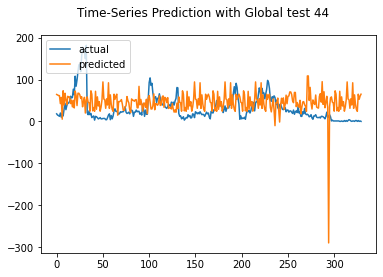

Test MAE: 36.501
Test RMSE: 46.180
Test sMAPE: 96.435
Test R Squared: -1.207
{'mae': 36.500846055059725, 'rmse': 46.18043024727158, 'smape': 96.43452688322216, 'r2': -1.2067744710880666}


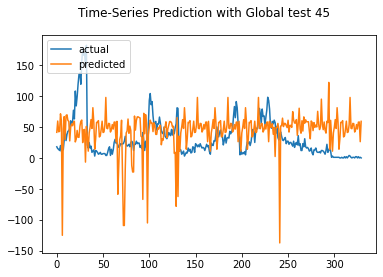

Test MAE: 34.170
Test RMSE: 41.920
Test sMAPE: 91.612
Test R Squared: -0.818
{'mae': 34.170289567383854, 'rmse': 41.919898572384085, 'smape': 91.61176456867801, 'r2': -0.818370797020074}


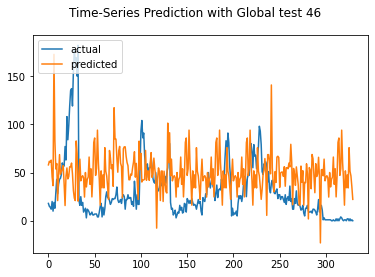

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 34.538
Test RMSE: 44.006
Test sMAPE: 94.179
Test R Squared: -1.004
{'mae': 34.538283115806, 'rmse': 44.0064419434571, 'smape': 94.17921535406681, 'r2': -1.0038929323305688}


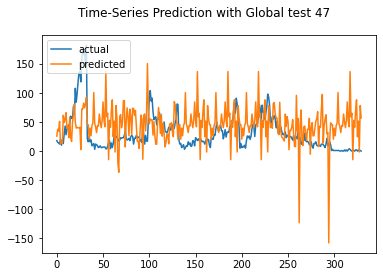

Test MAE: 32.304
Test RMSE: 40.660
Test sMAPE: 91.573
Test R Squared: -0.711
{'mae': 32.30386900034818, 'rmse': 40.660485141962, 'smape': 91.57325179528414, 'r2': -0.710752226645021}


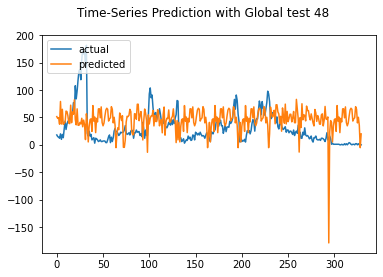

Test MAE: 33.449
Test RMSE: 40.672
Test sMAPE: 99.295
Test R Squared: -0.712
{'mae': 33.44873929421107, 'rmse': 40.67219207987876, 'smape': 99.2946693596137, 'r2': -0.7117374855869452}


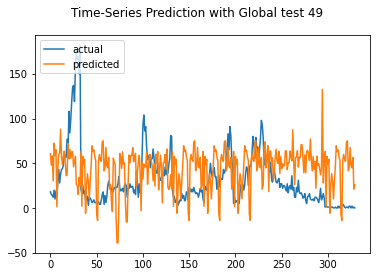

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 33.931
Test RMSE: 43.904
Test sMAPE: 96.206
Test R Squared: -0.995
{'mae': 33.93133584441561, 'rmse': 43.90391680480896, 'smape': 96.20585190690721, 'r2': -0.9945665670917159}


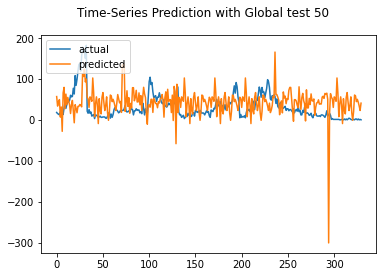

Test MAE: 28.238
Test RMSE: 37.249
Test sMAPE: 87.137
Test R Squared: -0.436
{'mae': 28.238005280370512, 'rmse': 37.248578318590454, 'smape': 87.13692578284149, 'r2': -0.43569241084485855}


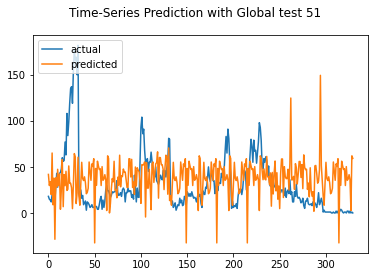

Test MAE: 32.898
Test RMSE: 39.884
Test sMAPE: 90.066
Test R Squared: -0.646
{'mae': 32.898217748873165, 'rmse': 39.883546601423596, 'smape': 90.06607425367152, 'r2': -0.6459989078558235}


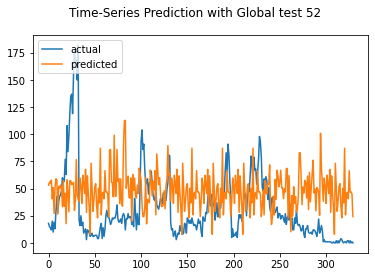

Test MAE: 32.814
Test RMSE: 42.049
Test sMAPE: 89.294
Test R Squared: -0.830
{'mae': 32.81370796633489, 'rmse': 42.04896980348709, 'smape': 89.29427923940403, 'r2': -0.8295855510942296}


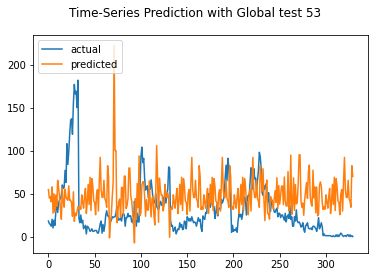

Test MAE: 30.054
Test RMSE: 39.375
Test sMAPE: 84.108
Test R Squared: -0.604
{'mae': 30.05406973145225, 'rmse': 39.37524279609355, 'smape': 84.10763357500285, 'r2': -0.604310741110353}


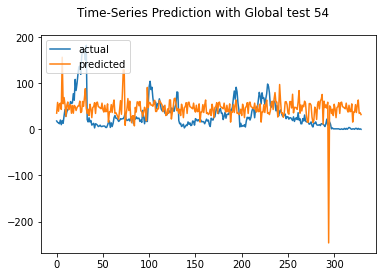

Test MAE: 32.479
Test RMSE: 48.488
Test sMAPE: 91.153
Test R Squared: -1.433
{'mae': 32.47895137721842, 'rmse': 48.4880477019107, 'smape': 91.1531121880736, 'r2': -1.4328279586072785}


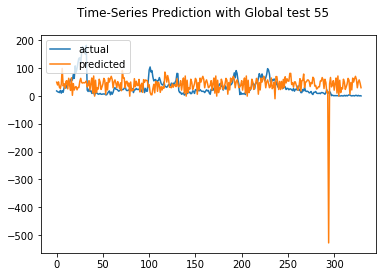

Test MAE: 26.926
Test RMSE: 35.439
Test sMAPE: 81.554
Test R Squared: -0.300
{'mae': 26.925762594107425, 'rmse': 35.43885538757418, 'smape': 81.55396619229128, 'r2': -0.29957507915699644}


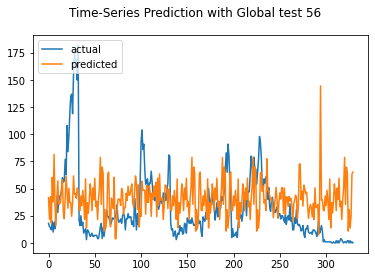

Test MAE: 35.613
Test RMSE: 42.852
Test sMAPE: 91.703
Test R Squared: -0.900
{'mae': 35.61260328726335, 'rmse': 42.85241112746446, 'smape': 91.70297182388894, 'r2': -0.9001703076469951}


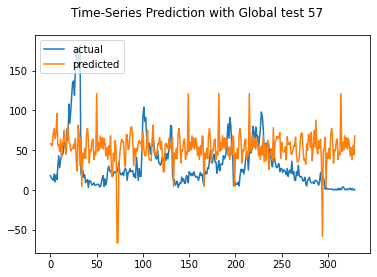

Test MAE: 36.190
Test RMSE: 44.026
Test sMAPE: 91.735
Test R Squared: -1.006
{'mae': 36.18952827345241, 'rmse': 44.02555020823156, 'smape': 91.73480066915322, 'r2': -1.0056335515802854}


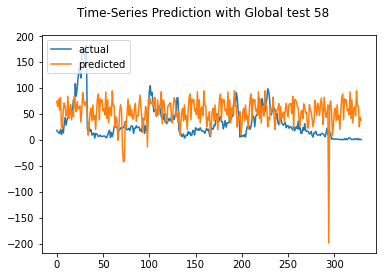

Test MAE: 34.091
Test RMSE: 39.865
Test sMAPE: 93.289
Test R Squared: -0.644
{'mae': 34.09056758736119, 'rmse': 39.86492450496667, 'smape': 93.28906990893535, 'r2': -0.6444621942401332}


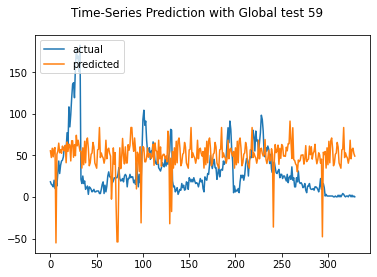

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 37.997
Test RMSE: 49.928
Test sMAPE: 96.718
Test R Squared: -1.580
{'mae': 37.99733896869601, 'rmse': 49.928438041802956, 'smape': 96.7175459213831, 'r2': -1.5795144277595723}


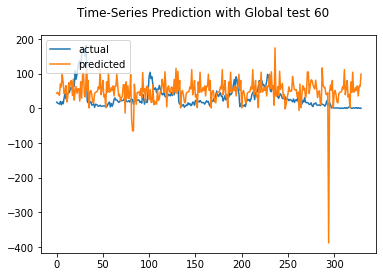

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 41.101
Test RMSE: 51.013
Test sMAPE: 108.455
Test R Squared: -1.693
{'mae': 41.100944989513266, 'rmse': 51.01309359516463, 'smape': 108.45536142577859, 'r2': -1.692807599661248}


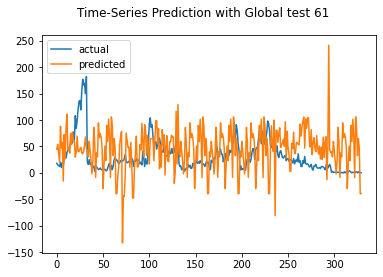

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 34.769
Test RMSE: 43.711
Test sMAPE: 90.765
Test R Squared: -0.977
{'mae': 34.76941637162006, 'rmse': 43.71147514319829, 'smape': 90.76470131037735, 'r2': -0.9771195370896999}


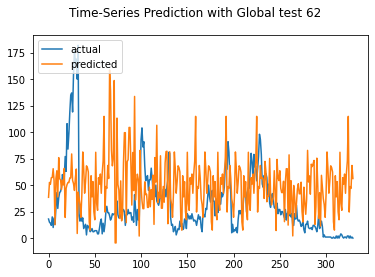

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 36.803
Test RMSE: 45.349
Test sMAPE: 92.520
Test R Squared: -1.128
{'mae': 36.80281694874619, 'rmse': 45.34894306659274, 'smape': 92.519723567885, 'r2': -1.1280231136551988}


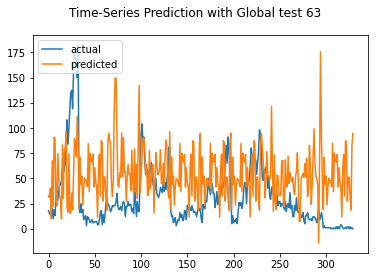

Test MAE: 34.449
Test RMSE: 40.529
Test sMAPE: 91.339
Test R Squared: -0.700
{'mae': 34.44934613668558, 'rmse': 40.529399523643846, 'smape': 91.33913158877247, 'r2': -0.6997393956866369}


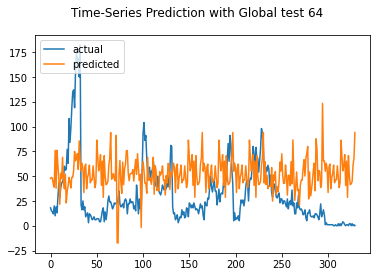

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 40.786
Test RMSE: 51.999
Test sMAPE: 107.440
Test R Squared: -1.798
{'mae': 40.78555853475224, 'rmse': 51.99935687045867, 'smape': 107.44006608362115, 'r2': -1.7979370955522214}


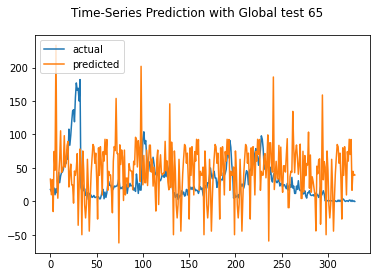

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 38.259
Test RMSE: 51.659
Test sMAPE: 97.442
Test R Squared: -1.761
{'mae': 38.25933299958706, 'rmse': 51.65898723398213, 'smape': 97.44164524355583, 'r2': -1.7614283358251361}


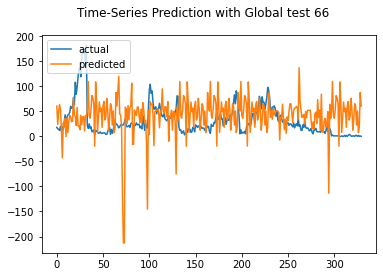

Test MAE: 37.472
Test RMSE: 46.359
Test sMAPE: 94.052
Test R Squared: -1.224
{'mae': 37.471844982378414, 'rmse': 46.35897536509607, 'smape': 94.05222761305535, 'r2': -1.223871344124586}


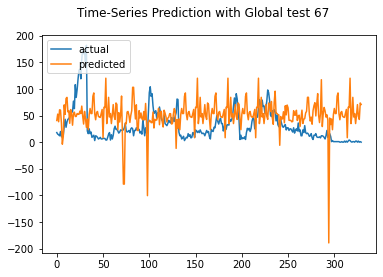

Test MAE: 34.619
Test RMSE: 41.291
Test sMAPE: 91.062
Test R Squared: -0.764
{'mae': 34.61948294206099, 'rmse': 41.290508279898965, 'smape': 91.06171973143985, 'r2': -0.764178234495692}


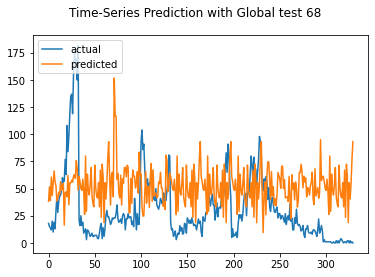

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 32.741
Test RMSE: 52.531
Test sMAPE: 104.501
Test R Squared: -1.855
{'mae': 32.741301491405025, 'rmse': 52.53129083103455, 'smape': 104.50082183330521, 'r2': -1.8554735851383617}


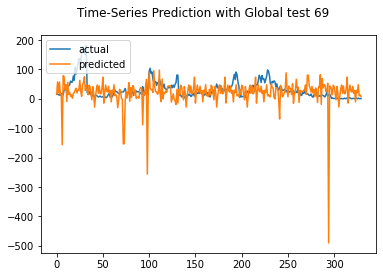

Test MAE: 32.740
Test RMSE: 41.000
Test sMAPE: 95.231
Test R Squared: -0.739
{'mae': 32.74016446029824, 'rmse': 40.999964804266654, 'smape': 95.23121047764644, 'r2': -0.7394380640003719}


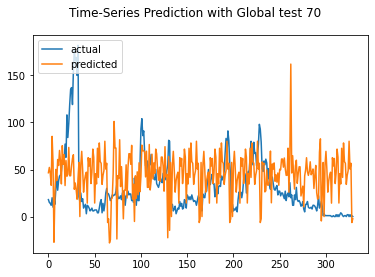

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 37.203
Test RMSE: 49.575
Test sMAPE: 98.343
Test R Squared: -1.543
{'mae': 37.20282331289667, 'rmse': 49.574841053955744, 'smape': 98.34345916771947, 'r2': -1.5431071714349445}


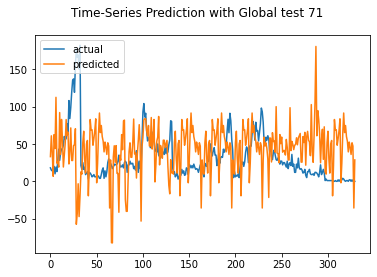

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 30.508
Test RMSE: 38.427
Test sMAPE: 93.573
Test R Squared: -0.528
{'mae': 30.507794893510415, 'rmse': 38.42741541036045, 'smape': 93.57332921082623, 'r2': -0.5280035109304977}


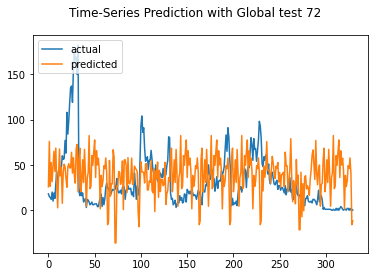

Test MAE: 34.103
Test RMSE: 46.924
Test sMAPE: 96.606
Test R Squared: -1.278
{'mae': 34.103491503632426, 'rmse': 46.924202381204054, 'smape': 96.60618718636002, 'r2': -1.278430575756226}


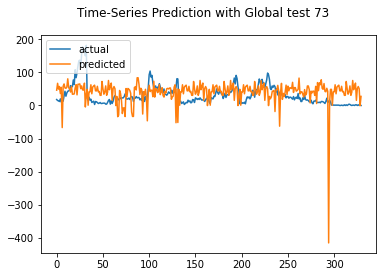

Test MAE: 30.687
Test RMSE: 39.001
Test sMAPE: 88.720
Test R Squared: -0.574
{'mae': 30.68687825266159, 'rmse': 39.001210541257684, 'smape': 88.72047360756932, 'r2': -0.5739762534599837}


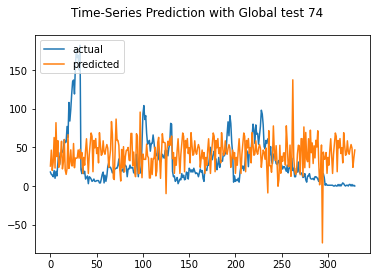

Test MAE: 29.265
Test RMSE: 44.788
Test sMAPE: 84.767
Test R Squared: -1.076
{'mae': 29.265033646966472, 'rmse': 44.78791366738738, 'smape': 84.76728646987088, 'r2': -1.075695608308867}


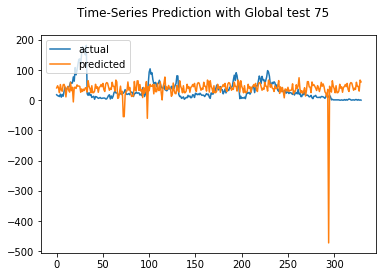

Test MAE: 35.438
Test RMSE: 44.499
Test sMAPE: 91.125
Test R Squared: -1.049
{'mae': 35.437953278512666, 'rmse': 44.49885611863876, 'smape': 91.12519639494715, 'r2': -1.0489893264346541}


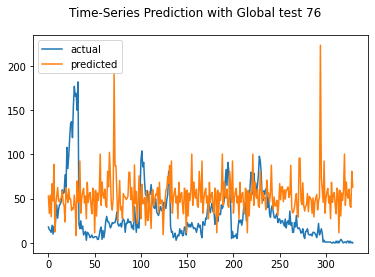

Test MAE: 40.786
Test RMSE: 63.939
Test sMAPE: 98.476
Test R Squared: -3.230
{'mae': 40.786217342723496, 'rmse': 63.93877005137067, 'smape': 98.4758934950058, 'r2': -3.2302940572855547}


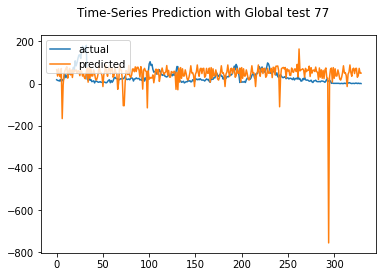

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 39.526
Test RMSE: 59.232
Test sMAPE: 114.364
Test R Squared: -2.630
{'mae': 39.526344604474126, 'rmse': 59.23187238222265, 'smape': 114.36446584689031, 'r2': -2.630387008460647}


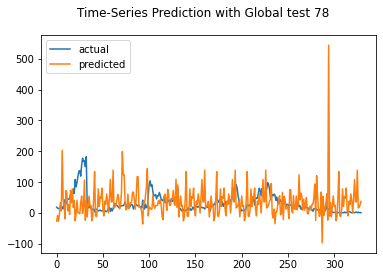

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 33.430
Test RMSE: 43.322
Test sMAPE: 88.927
Test R Squared: -0.942
{'mae': 33.429683513713606, 'rmse': 43.321557559284436, 'smape': 88.927036343164, 'r2': -0.9420040303938013}


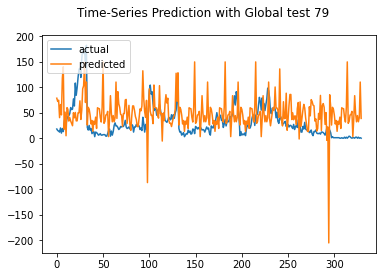

Test MAE: 33.520
Test RMSE: 56.212
Test sMAPE: 97.617
Test R Squared: -2.270
{'mae': 33.51985592137684, 'rmse': 56.21189800509049, 'smape': 97.616741202399, 'r2': -2.2696291815328564}


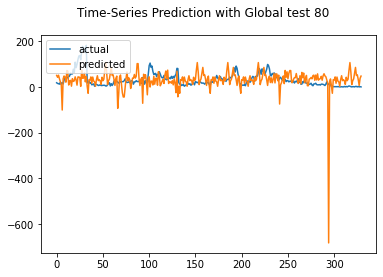

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 42.998
Test RMSE: 54.388
Test sMAPE: 100.857
Test R Squared: -2.061
{'mae': 42.99751710169243, 'rmse': 54.38830540604316, 'smape': 100.85742964646529, 'r2': -2.060927596061219}


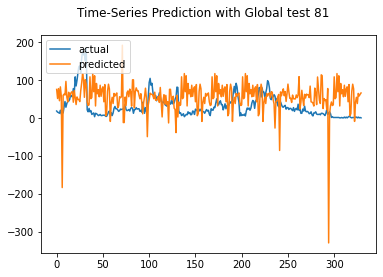

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 36.584
Test RMSE: 46.936
Test sMAPE: 98.382
Test R Squared: -1.280
{'mae': 36.58380101196693, 'rmse': 46.93570164406512, 'smape': 98.38184672260235, 'r2': -1.2795474187112856}


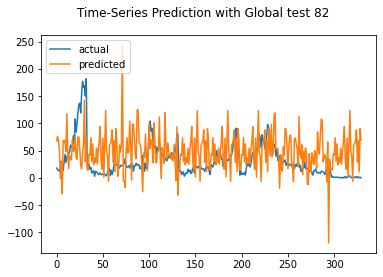

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 36.282
Test RMSE: 46.409
Test sMAPE: 91.593
Test R Squared: -1.229
{'mae': 36.28171434691458, 'rmse': 46.40917581211919, 'smape': 91.5927325375779, 'r2': -1.2286902504875403}


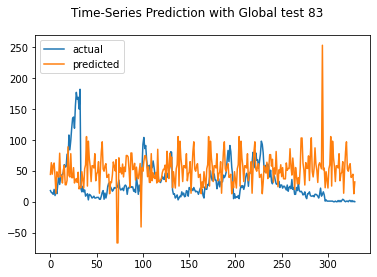

Test MAE: 39.509
Test RMSE: 48.715
Test sMAPE: 94.717
Test R Squared: -1.456
{'mae': 39.5088475892038, 'rmse': 48.71463265605953, 'smape': 94.71728143100415, 'r2': -1.4556183251744486}


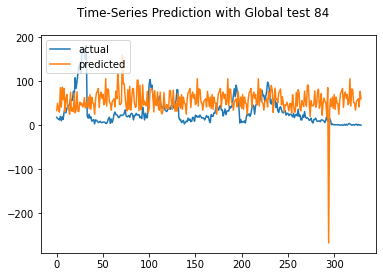

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 35.101
Test RMSE: 47.812
Test sMAPE: 95.685
Test R Squared: -1.365
{'mae': 35.10094811609297, 'rmse': 47.81160244247943, 'smape': 95.68471919734118, 'r2': -1.3654218324967755}


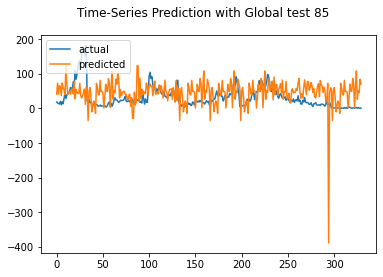

Test MAE: 32.794
Test RMSE: 40.058
Test sMAPE: 89.161
Test R Squared: -0.660
{'mae': 32.79420831853693, 'rmse': 40.057973592331884, 'smape': 89.1610334932106, 'r2': -0.6604276374033997}


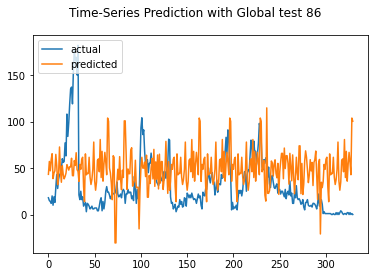

Test MAE: 30.951
Test RMSE: 41.173
Test sMAPE: 88.743
Test R Squared: -0.754
{'mae': 30.950812215877303, 'rmse': 41.173286418687425, 'smape': 88.7427794371579, 'r2': -0.7541756108161548}


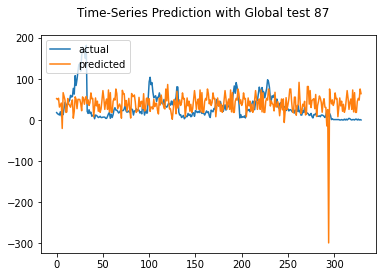

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 39.318
Test RMSE: 47.569
Test sMAPE: 100.760
Test R Squared: -1.341
{'mae': 39.31834996432969, 'rmse': 47.569170225407106, 'smape': 100.76046259570985, 'r2': -1.3414945613486018}


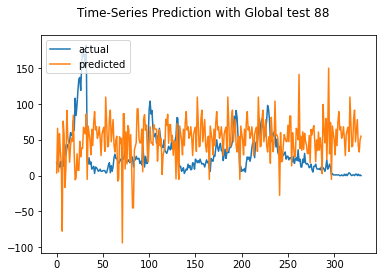

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 42.140
Test RMSE: 52.791
Test sMAPE: 102.627
Test R Squared: -1.884
{'mae': 42.140395337885074, 'rmse': 52.79114915059803, 'smape': 102.62691593196867, 'r2': -1.883793995310743}


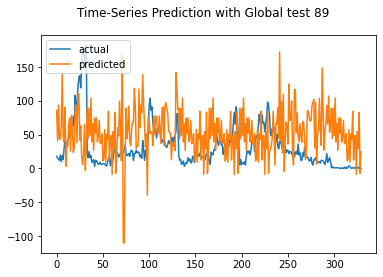

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 38.754
Test RMSE: 53.560
Test sMAPE: 103.659
Test R Squared: -1.968
{'mae': 38.753508201523715, 'rmse': 53.55976003626511, 'smape': 103.65886185639437, 'r2': -1.9683782914395929}


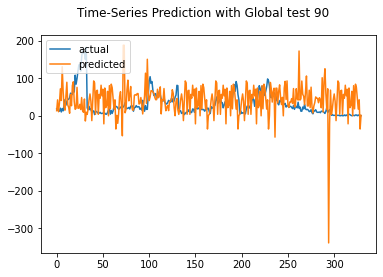

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 47.321
Test RMSE: 65.401
Test sMAPE: 127.089
Test R Squared: -3.426
{'mae': 47.32115343682694, 'rmse': 65.40094119750462, 'smape': 127.08876119598801, 'r2': -3.425985618569257}


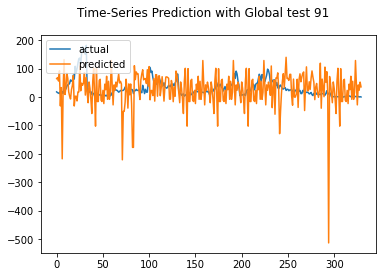

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 31.904
Test RMSE: 39.361
Test sMAPE: 96.991
Test R Squared: -0.603
{'mae': 31.904218518011497, 'rmse': 39.36147101962925, 'smape': 96.99110445010952, 'r2': -0.6031886987541741}


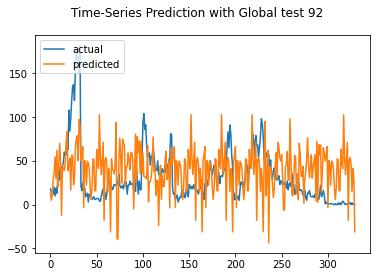

Test MAE: 34.554
Test RMSE: 46.410
Test sMAPE: 89.348
Test R Squared: -1.229
{'mae': 34.55353119590065, 'rmse': 46.409798383135254, 'smape': 89.34768629390024, 'r2': -1.2287500458722294}


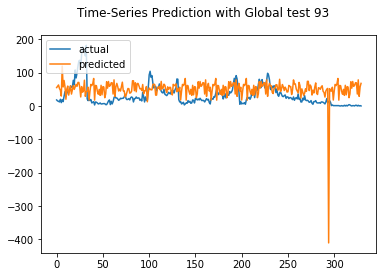

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 31.416
Test RMSE: 43.122
Test sMAPE: 88.464
Test R Squared: -0.924
{'mae': 31.416465616226198, 'rmse': 43.12245198644579, 'smape': 88.4644887360952, 'r2': -0.9241941779990355}


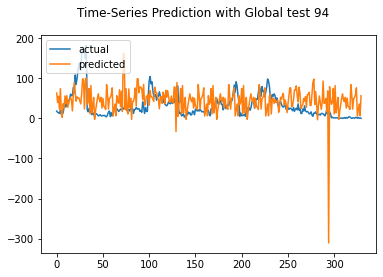

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 45.942
Test RMSE: 65.406
Test sMAPE: 104.580
Test R Squared: -3.427
{'mae': 45.94184265899839, 'rmse': 65.40610839253453, 'smape': 104.58003912847914, 'r2': -3.4266850223981704}


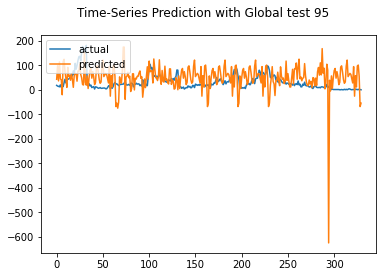

Test MAE: 31.055
Test RMSE: 40.427
Test sMAPE: 89.283
Test R Squared: -0.691
{'mae': 31.054713707078587, 'rmse': 40.42675431752137, 'smape': 89.28296422192868, 'r2': -0.6911407403787295}


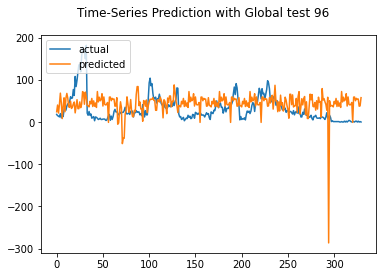

Test MAE: 33.371
Test RMSE: 45.833
Test sMAPE: 89.625
Test R Squared: -1.174
{'mae': 33.370968860568425, 'rmse': 45.83250521657448, 'smape': 89.62459357249111, 'r2': -1.1736478940997461}


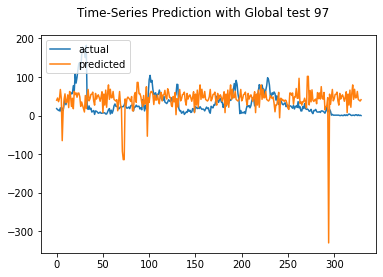

Test MAE: 32.793
Test RMSE: 44.523
Test sMAPE: 91.496
Test R Squared: -1.051
{'mae': 32.79271095286716, 'rmse': 44.522678668375725, 'smape': 91.49627442513362, 'r2': -1.0511837745727988}


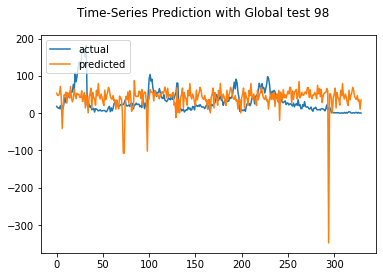

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 32.987
Test RMSE: 42.142
Test sMAPE: 95.137
Test R Squared: -0.838
{'mae': 32.98703316919731, 'rmse': 42.14203064733532, 'smape': 95.13704424351846, 'r2': -0.8376928214954424}


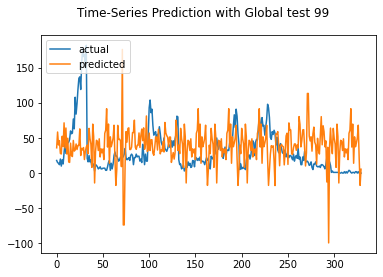

rmse : average=46.919, std=6.838
mae : average=35.903, std=4.345
smape : average=95.687, std=7.187
r2 : average=-1.326, std=0.731


([46.918549966426106, 6.8379557055951246],
 [35.902993628428824, 4.344878701938538],
 [95.68660008049227, 7.1867854751956015],
 [-1.3262648942861022, 0.7312946838896188])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')